In [4]:
import nengo
import numpy as np
import math
import matplotlib.pyplot as plt
from nengo.utils.matplotlib import rasterplot
from nengo.utils.ensemble import tuning_curves
from nengo.processes import Piecewise

def inverse_kinematics_numeric(L = [1, 1, 1], neurons_per_rad = 300, adaptation_rate=0.5):

    model = nengo.Network()
    
    with model:
        END_EFFECTOR_COORIDINATES_TOLERANCE = 0.001 
    
        def scale_up_angle(x):
            return x * np.pi + np.pi
            
        def scale_down_angle(x):
            return (x - np.pi) / (np.pi)

        model.stim_x = nengo.Node(output=None, size_in=1)
        model.stim_y = nengo.Node(output=None, size_in=1)
        
        
        model.array = nengo.Ensemble(n_neurons=int(6*neurons_per_rad), 
                                    dimensions=2, radius=np.sqrt(2*L[0]**2), seed=10) 
        model.array_direct = nengo.Ensemble(n_neurons=1, dimensions=2,
                                           neuron_type=nengo.Direct())
        
        model.array_probe = []
        for i, ens in enumerate([model.array, model.array_direct]):
            model.array_probe.append(nengo.Probe(ens, synapse=0.01))
            nengo.Connection(model.stim_x, ens[0])
            nengo.Connection(model.stim_y, ens[1])
            
            
        
        
        model.stim_teta0 = nengo.Node(output=None, size_in=1)
       

        # BC = Before Scale Up
        model.BS_teta0 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        model.BS_teta0_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        nengo.Connection(model.stim_teta0, model.BS_teta0)
        nengo.Connection(model.stim_teta0, model.BS_teta0_direct)
        
        model.teta0 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=np.pi, seed=10)
        model.spikes_teta0 = nengo.Probe(model.teta0.neurons)
        model.teta0_direct = nengo.Ensemble(n_neurons=1, dimensions=1,neuron_type=nengo.Direct())
        
        nengo.Connection(model.BS_teta0, model.teta0, function=scale_up_angle)
        nengo.Connection(model.BS_teta0_direct, model.teta0_direct, function=scale_up_angle)
      
        
        #calculate Y - according to FK
        model.sin_teta0=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        model.sin_teta0_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        def calculate_sinTeta(teta): 
            return np.sin(teta)
        
        nengo.Connection(model.teta0, model.sin_teta0,function=calculate_sinTeta)
        nengo.Connection(model.teta0_direct, model.sin_teta0_direct,function=calculate_sinTeta)
        
        model.Y = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=L[0], seed=10)
        model.Y_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
       
        
        def calculate_l0_Teta(teta): 
            return L[0]*teta
        
        
        nengo.Connection(model.sin_teta0,model.Y,function=calculate_l0_Teta)
        nengo.Connection(model.sin_teta0_direct,model.Y_direct,function=calculate_l0_Teta)
       
       
        # calculate X - according to FK
        model.cos_teta0=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        model.cos_teta0_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        
        def calculate_cosTeta(teta): 
            return np.cos(teta)
        
        nengo.Connection(model.teta0, model.cos_teta0,function=calculate_cosTeta)
        nengo.Connection(model.teta0_direct, model.cos_teta0_direct,function=calculate_cosTeta)
      
        model.X = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=L[0], seed=10)
        model.X_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
      
        nengo.Connection(model.cos_teta0, model.X,function=calculate_l0_Teta)
        nengo.Connection(model.cos_teta0_direct, model.X_direct,function=calculate_l0_Teta)
     
       
    
       
        
        #calculate Deltas
        model.xDelta=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=L[0], seed=10)
        model.yDelta=nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=L[0], seed=10)
        
        model.xDelta_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.yDelta_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        nengo.Connection(model.array[0], model.xDelta)
        nengo.Connection(model.X, model.xDelta, transform=-1)
        nengo.Connection(model.array[1], model.yDelta)
        nengo.Connection(model.Y, model.yDelta, transform=-1)
        
        nengo.Connection(model.array_direct[0], model.xDelta_direct)
        nengo.Connection(model.X_direct, model.xDelta_direct, transform=-1)
        nengo.Connection(model.array_direct[1], model.yDelta_direct)
        nengo.Connection(model.Y_direct, model.yDelta_direct, transform=-1)
        
        
        #calculate if to keep calculating
        model.IsPoseEqualtoEndEffectorX = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        model.IsPoseEqualtoEndEffectorY = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)
        
        model.IsPoseEqualtoEndEffectorX_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.IsPoseEqualtoEndEffectorY_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        
        def check_difference(Delta):
            if Delta < 0:
                if Delta > (END_EFFECTOR_COORIDINATES_TOLERANCE * -1): return 1
            else:
                if Delta < END_EFFECTOR_COORIDINATES_TOLERANCE: return 1
            return 0
        
        nengo.Connection(model.xDelta,model.IsPoseEqualtoEndEffectorX, function=check_difference)
        nengo.Connection(model.yDelta,model.IsPoseEqualtoEndEffectorY, function=check_difference)
        
        nengo.Connection(model.xDelta_direct,model.IsPoseEqualtoEndEffectorX_direct, function=check_difference)
        nengo.Connection(model.yDelta_direct,model.IsPoseEqualtoEndEffectorY_direct, function=check_difference)
        
        model.IsPoseEqualtoEndEffector_array = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=2, 
                                                              radius=np.sqrt(2*1**2), seed=10)
        model.IsPoseEqualtoEndEffector_array_direct = nengo.Ensemble(n_neurons=1, dimensions=2, neuron_type=nengo.Direct())
        
        nengo.Connection(model.IsPoseEqualtoEndEffectorX,model.IsPoseEqualtoEndEffector_array[0])
        nengo.Connection(model.IsPoseEqualtoEndEffectorY,model.IsPoseEqualtoEndEffector_array[1])
        
        nengo.Connection(model.IsPoseEqualtoEndEffectorX_direct,model.IsPoseEqualtoEndEffector_array_direct[0])
        nengo.Connection(model.IsPoseEqualtoEndEffectorY_direct,model.IsPoseEqualtoEndEffector_array_direct[1])
       
        model.IsPoseEqualtoEndEffector = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=1, seed=10)    
        model.IsPoseEqualtoEndEffector_direct = nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        def multiply2(array):
            return array[0]*array[1]
        
        nengo.Connection(model.IsPoseEqualtoEndEffector_array,model.IsPoseEqualtoEndEffector, function=multiply2)
        nengo.Connection(model.IsPoseEqualtoEndEffector_array_direct,model.IsPoseEqualtoEndEffector_direct, function=multiply2)
        
        
        
         # calculate Jacobian
            # J = np.array([[a11],
            #           [a21],       
            #           ])
        
        
        model.a11 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=L[0], seed=10)
        model.a21 = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=L[0], seed=10)
        
        model.a11_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        model.a21_direct=nengo.Ensemble(n_neurons=1, dimensions=1, neuron_type=nengo.Direct())
        
        nengo.Connection(model.Y,model.a11,transform=-1)
        nengo.Connection(model.X,model.a21)
        
        nengo.Connection(model.Y_direct,model.a11_direct,transform=-1)
        nengo.Connection(model.X_direct,model.a21_direct)
        
        model.J_ens = nengo.Ensemble(n_neurons=9*neurons_per_rad, dimensions=5, 
                               radius=np.sqrt(4*L[0]**2+1), seed=10)
        model.J_ens_direct=nengo.Ensemble(n_neurons=1, dimensions=5, neuron_type=nengo.Direct())
        
        nengo.Connection(model.a11,model.J_ens[0])
        nengo.Connection(model.a21,model.J_ens[1]) 
        nengo.Connection(model.xDelta,model.J_ens[2])
        nengo.Connection(model.yDelta,model.J_ens[3])
        nengo.Connection(model.IsPoseEqualtoEndEffector,model.J_ens[4])
        
        nengo.Connection(model.a11_direct,model.J_ens_direct[0])
        nengo.Connection(model.a21_direct,model.J_ens_direct[1]) 
        nengo.Connection(model.xDelta_direct,model.J_ens_direct[2])
        nengo.Connection(model.yDelta_direct,model.J_ens_direct[3])
        nengo.Connection(model.IsPoseEqualtoEndEffector_direct,model.J_ens_direct[4])
        
        model.teta0_final = nengo.Ensemble(n_neurons=3*neurons_per_rad, dimensions=1, radius=np.pi, seed=10)
        model.teta0_final_direct = nengo.Ensemble(n_neurons=1, dimensions=1,neuron_type=nengo.Direct())
       
        
        def calculate_J_theta0(J):
            newAngles=[0]
            if(J[4] > 0):
                j = np.array([[J[0]], [J[1]]])
        
                inverseJ = np.linalg.pinv(j) # Jacobian pseudo inverse
                deltaMatrix = np.array([J[2], J[3]]).T # x, y, z, phie delta change vector
                newAngles = inverseJ.dot(deltaMatrix) # J^-1 dot product with x, y, z, phie delta change vector
            return newAngles[0]*adaptation_rate
        
        
        
        #adding the new angles values according to J
        nengo.Connection(model.J_ens,model.teta0_final,function=calculate_J_theta0)
        nengo.Connection(model.teta0,model.teta0_final)
        
        nengo.Connection(model.J_ens_direct,model.teta0_final_direct,function=calculate_J_theta0)
        nengo.Connection(model.teta0_direct,model.teta0_final_direct)
        
        
        #update the original angles in order to keep calculate
        nengo.Connection(model.teta0_final,model.teta0)
        nengo.Connection(model.teta0_final_direct,model.teta0_direct)
        
        
        model.probe_teta0 = nengo.Probe(model.teta0, synapse=0.01)
        model.probe_teta0_direct = nengo.Probe(model.teta0_direct, synapse=0.01)
       
    
        return model
    
    
model = nengo.Network(label='Inverse Kinematics numeric')
with model:
    
    def scale_down_angle(x):
            return (x - np.pi) / (np.pi)
        
    stim_x = nengo.Node(Piecewise({0: 0}))
    stim_y = nengo.Node(Piecewise({0: 1}))
  
    
    stim_teta0 = nengo.Node(Piecewise({0: scale_down_angle(0)}))
   
    ik = inverse_kinematics_numeric()
    
    nengo.Connection(stim_x, ik.stim_x)
    nengo.Connection(stim_y, ik.stim_y)
    
    nengo.Connection(stim_teta0, ik.stim_teta0)
    
    
    print(model.n_neurons)       

18017


In [5]:
with nengo.Simulator(model) as sim:
    sim.run(4)
    
teta0_e = np.sqrt(sum((sim.data[ik.probe_teta0] - sim.data[ik.probe_teta0_direct])**2)) 

print('teta0_error: ', teta0_e)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

teta0_error:  [7.62283568]


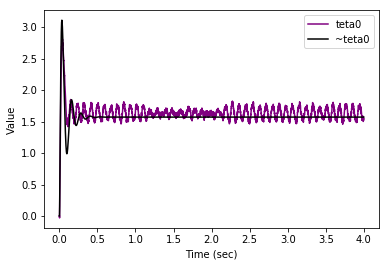

In [6]:
plt.figure()
plt.xlabel("Time (sec)")
plt.ylabel("Value");
plt.plot(sim.trange(), sim.data[ik.probe_teta0], color = 'purple',label="teta0")
plt.plot(sim.trange(), sim.data[ik.probe_teta0_direct], color = 'black',label="~teta0")
plt.legend()
plt.savefig('loc.jpg', dpi=350)